# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

### Start of assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns

### Python Model Creation

In [2]:
import sys  
sys.path.insert(0, './model/')
import PredPrey as PP

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]

#Define the Python model
py_model = Model('Python', function=PP.PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

In [3]:
processes = 10

In [4]:
%%html
<link rel="stylesheet" href="style/style.css">

# Linear regression on Prey
The sampling technique chosen for this part is Latin Hypercube Sampling as recommended in the course materials. This method of sampling makes sure that there are no points of the analysis that are not "investigated". 

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    experiments, outcomes = perform_experiments(py_model, 50, uncertainty_sampling=LHS)

## Look at final values of prey
The final values of prey are shown in the figure below. 

In [6]:
prey = pd.DataFrame(outcomes["prey"]).T
preyfinal = pd.DataFrame(prey.iloc[-1])

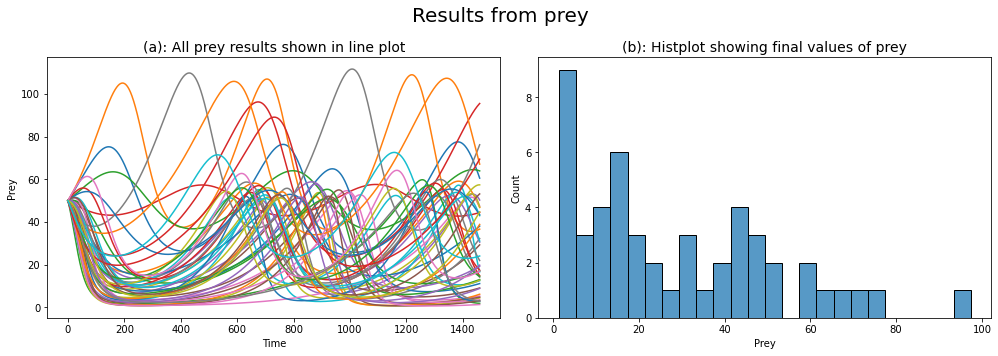

In [7]:
fig, ax = plt.subplots(figsize=(20,15), ncols=2)
prey.plot(legend=None, figsize=(14,5), ax = ax[0])
sns.histplot(data=preyfinal, ax=ax[1], legend=None, binwidth=4)
fig.suptitle('Results from prey', fontsize=20)
ax[0].set_title('(a): All prey results shown in line plot', fontsize=14)
ax[1].set_title('(b): Histplot showing final values of prey', fontsize=14)
ax[1].set_xlabel('Prey')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Prey')
fig.tight_layout()
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
 Figure (a) shows an overview of all the different model runs. Visual analysis shows that the number of 'large' outliers is around 9. At least the runs, where the model differst more from the rest of the model behaviour. 
- Figre (b) shows the final values of the prey model. Some gaps can be identified there, which means that certain scores of prey are not in the final values. 
</div>


## *Final results* - regression

In [8]:
X = experiments[["predation_rate", "predator_efficiency", "predator_loss_rate", "prey_birth_rate"]]
X = sm.add_constant(X)
Y = preyfinal

In [9]:
# do the regression
mod_fv = sm.OLS(Y, X).fit()

In [10]:
#results of the regression
mod_fv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   1460   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     8.145
Date:                Thu, 13 May 2021   Prob (F-statistic):           4.98e-05
Time:                        10:14:34   Log-Likelihood:                -213.42
No. Observations:                  50   AIC:                             436.8
Df Residuals:                      45   BIC:                             446.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  41.7023     21.235      1.964      0.056      -1.067      84.471
predation_rate      -1095.5199   3585.011     -0.306      0.761   -8316.102    6125.062
predator_efficiency -1.401e+04   2992.038     -4.681      0.000      -2e+04   -7980.697
predator_loss_rate    617.0763    223.975      2.755      0.008     165.968    1068.185
prey_birth_rate      -514.3727    446.993     -1.151      0.256   -1414.663     385.918
==============================================================================
Omnibus:                        4.025   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.877
Skew:                           0.659   Prob(JB):                        0.144
Kurtosis:                       2.651   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

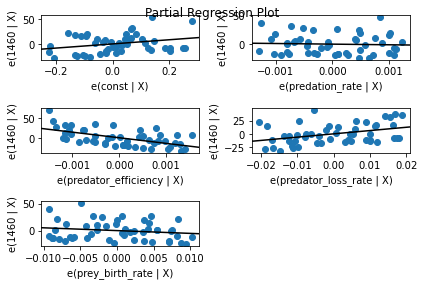

In [11]:
sm.graphics.plot_partregress_grid(mod_fv)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>

## *Mean values* - regression

In [12]:
Y = [i.mean() for i in outcomes["prey"]]

In [13]:
mod_mean = sm.OLS(Y, X).fit()

In [14]:
mod_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     84.11
Date:                Thu, 13 May 2021   Prob (F-statistic):           2.72e-20
Time:                        10:14:35   Log-Likelihood:                -149.94
No. Observations:                  50   AIC:                             309.9
Df Residuals:                      45   BIC:                             319.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.6286      5.967      3.625      0.001       9.611      33.646
predation_rate       -337.8055   1007.337     -0.335      0.739   -2366.687    1691.076
predator_efficiency -1.307e+04    840.721    -15.550      0.000   -1.48e+04   -1.14e+04
predator_loss_rate    574.0556     62.934      9.122      0.000     447.300     700.811
prey_birth_rate       170.4320    125.599      1.357      0.182     -82.537     423.401
==============================================================================
Omnibus:                        5.456   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.311
Skew:                           0.791   Prob(JB):                       0.0703
Kurtosis:                       2.791   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

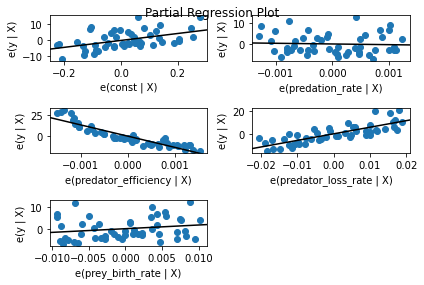

In [15]:
sm.graphics.plot_partregress_grid(mod_mean)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(const|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

## Standard deviations

In [16]:
Y = outcomes["prey"].std(axis=1)

In [17]:
mod_std = sm.OLS(Y, X).fit()

In [18]:
mod_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2.053
Date:                Thu, 13 May 2021   Prob (F-statistic):              0.103
Time:                        10:14:35   Log-Likelihood:                -127.77
No. Observations:                  50   AIC:                             265.5
Df Residuals:                      45   BIC:                             275.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.3545      3.829      3.488      0.001       5.642      21.067
predation_rate       1274.9269    646.445      1.972      0.055     -27.079    2576.933
predator_efficiency -1008.1594    539.521     -1.869      0.068   -2094.809      78.491
predator_loss_rate     46.5526     40.387      1.153      0.255     -34.791     127.896
prey_birth_rate        -7.2354     80.601     -0.090      0.929    -169.575     155.104
==============================================================================
Omnibus:                       12.441   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.776
Skew:                          -0.519   Prob(JB):                     9.30e-07
Kurtosis:                       6.501   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

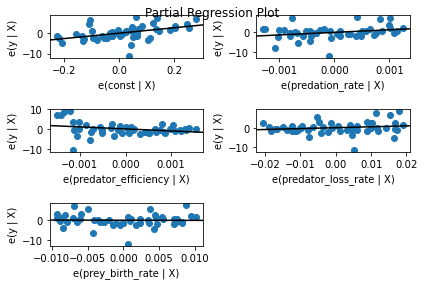

In [19]:
sm.graphics.plot_partregress_grid(mod_std)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

### Comparison of the coefficients
The following part is used to analysise the coefficients. 

In [20]:
params = pd.DataFrame(mod_fv.params, columns=["final"])
params["means"] = mod_mean.params
params["std"] = mod_std.params
params.drop(index="const", inplace=True)

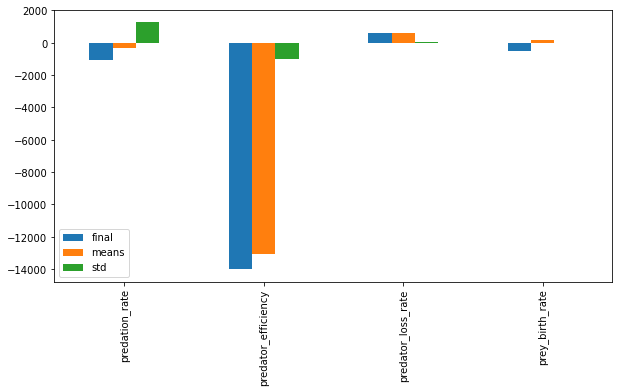

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
params.plot.bar(ax=ax)
plt.show()

### Comparison of rsquared

In [22]:
print(mod_fv.rsquared_adj)
print(mod_mean.rsquared_adj)
print(mod_std.rsquared_adj)

0.3683949190813274
0.8715388845508274
0.07915230628945169


<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x).
    <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

# Sobol
---
Start of the Sobol analysis

In [23]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    sa_experiments, sa_outcomes = perform_experiments(py_model, scenarios=50 * (2 * 4 + 2), uncertainty_sampling=SOBOL)

In [24]:
problem = get_SALib_problem(py_model.uncertainties)
Si = sobol.analyze(problem, sa_outcomes['prey'].ravel(), calc_second_order=True, print_to_console=False)

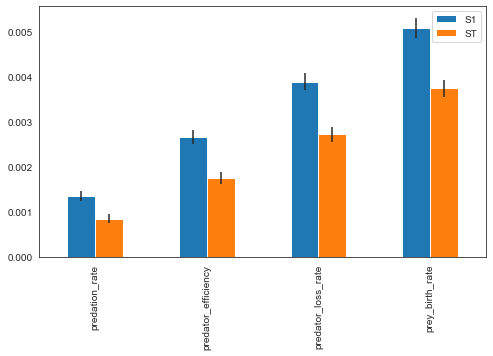

In [25]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x).
    <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

## Extra-trees analysis
---
Now continue with the extra-trees analysis

In [26]:
sobol_mean = pd.Series([i.mean() for i in sa_outcomes["prey"]]).astype('int')

In [27]:
sobol_std = pd.Series(sa_outcomes["prey"].std(axis=1)).astype('int')

In [28]:
sobol_final = pd.DataFrame(sa_outcomes["prey"]).T.iloc[-1]

In [29]:
scores = []
for y in [sobol_mean, sobol_std, sobol_final]:
    scores.append(feature_scoring.get_ex_feature_scores(sa_experiments, y, mode=RuleInductionType.REGRESSION, nr_trees=100, max_features=0.6)[0])

In [30]:
scores

[                            1
 0                            
 predator_efficiency  0.774507
 predator_loss_rate   0.201963
 prey_birth_rate      0.013045
 predation_rate       0.010486,
                             1
 0                            
 predation_rate       0.376279
 predator_efficiency  0.325292
 prey_birth_rate      0.166448
 predator_loss_rate   0.131981,
                             1
 0                            
 predator_efficiency  0.505296
 predator_loss_rate   0.215721
 prey_birth_rate      0.213166
 predation_rate       0.065816]

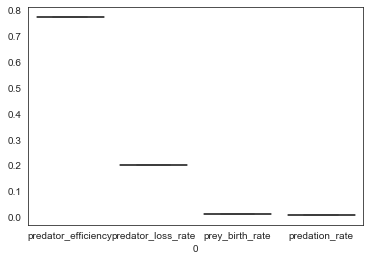

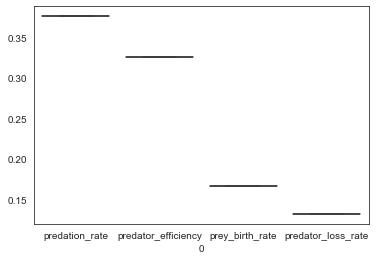

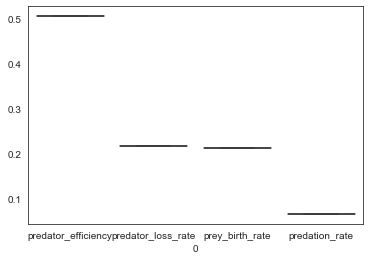

In [31]:
for i in scores:
    sns.boxplot(data=i.T)
    plt.show()

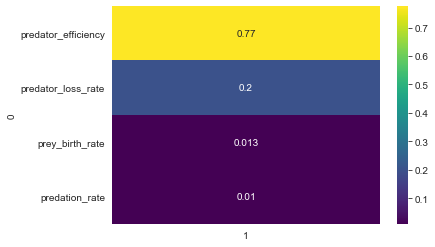

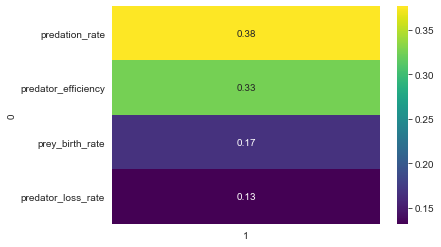

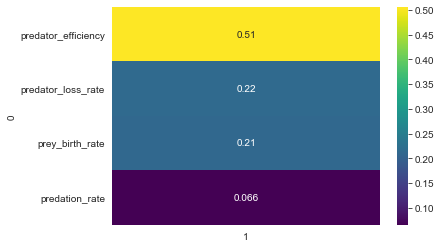

In [32]:
for i in scores:
    sns.heatmap(i, annot=True, cmap='viridis')
    plt.show()

In [33]:
scores

[                            1
 0                            
 predator_efficiency  0.774507
 predator_loss_rate   0.201963
 prey_birth_rate      0.013045
 predation_rate       0.010486,
                             1
 0                            
 predation_rate       0.376279
 predator_efficiency  0.325292
 prey_birth_rate      0.166448
 predator_loss_rate   0.131981,
                             1
 0                            
 predator_efficiency  0.505296
 predator_loss_rate   0.215721
 prey_birth_rate      0.213166
 predation_rate       0.065816]

In [34]:
scores_df = pd.concat(scores, axis=1, sort=False)

In [35]:
scores_list = scores_df.to_numpy()

In [36]:
scores_list

array([[0.77450657, 0.32529195, 0.50529621],
       [0.20196258, 0.13198059, 0.21572099],
       [0.01304474, 0.1664484 , 0.21316648],
       [0.01048611, 0.37627906, 0.06581632]])

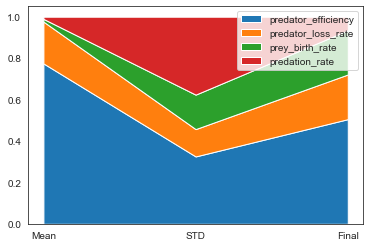

In [37]:
fig, ax = plt.subplots()
ax.stackplot(range(scores_list.shape[1]), scores_list, labels=scores[0].index.values)
plt.legend()
ax.set_xticks(range(3)) # <--- set the ticks first
ax.set_xticklabels(["Mean", "STD", "Final"])
plt.show()